# Buscando ponto de corte em imagem definido através do histograma de soma horizontal

Raciocínio:
- Verifica a posição `pos` do pico do histograma;
- caso o pico esteja na metade esquerda (`pos < n_intervalos/2`):
  - é preferível cortar no limite maior do intervalo (mais para a direita), então `limiar = intervalos[pos+1]`;
  - a condição de parada é quando um valor da soma horizontal for maior que o limiar (`y > limiar`);
- caso o pico esteja na metade direita (`pos >= n_intervalos/2`):
  - não é preciso escolher um ponto de corte mais à direita ou a esquerda, então `limiar = intervalos[pos]`;
  - a condição de parada é quando um valor da soma horizontal for menor que o limiar (`y < limiar`);
- de cima para baixo e vice-versa a imagem é varrida, em cada caso, quando a condição de parada for satisfeita, é traçada uma linha **roxa** no lugar.

In [1]:
import numpy as np
import seaborn as sns

from zipfile import ZipFile
from matplotlib import pyplot as plt
from skimage.io import imread

from img_edit import best_rgb, rgb_to_color

sns.set_style(style='darkgrid')
plt.gray()

LIMITE_DE_NORMALIZACAO = 8

COLOR_NAMES = ['vermelho', 'verde', 'azul']
COLOR_CODES = ['r-', 'g-', 'b-']

<Figure size 432x288 with 0 Axes>

In [2]:
path_list = []
with ZipFile('./toras.zip') as zip_file:
  for path in zip_file.namelist():
    if '__MAC' not in path \
        and '.JPG' in path:
      path_list.append(f'./toras.zip/{path}')

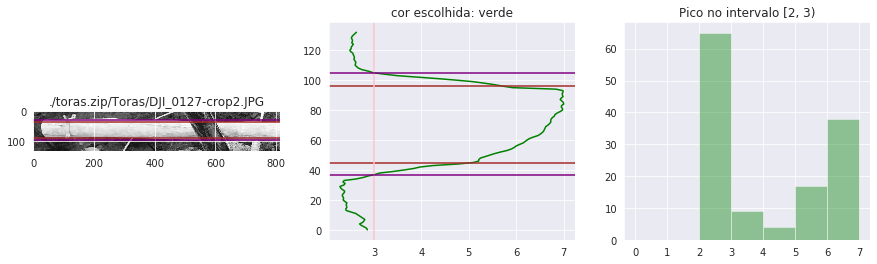

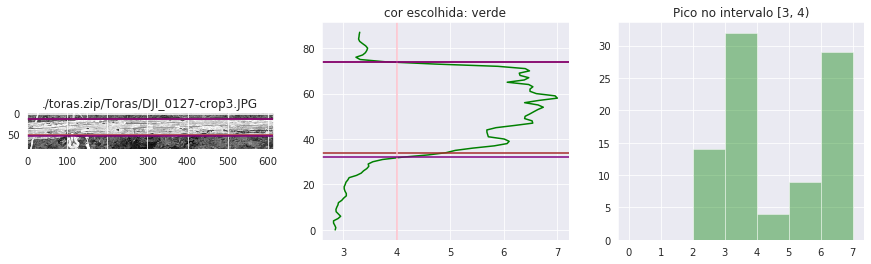

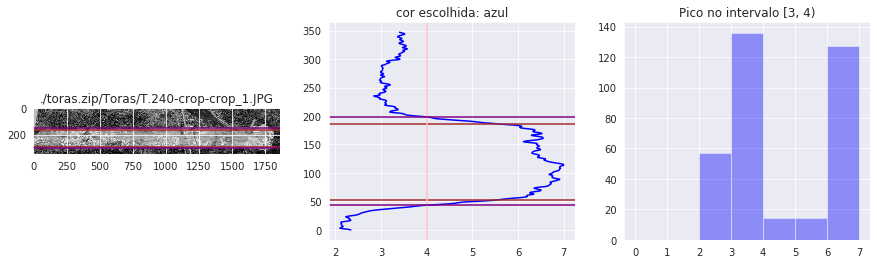

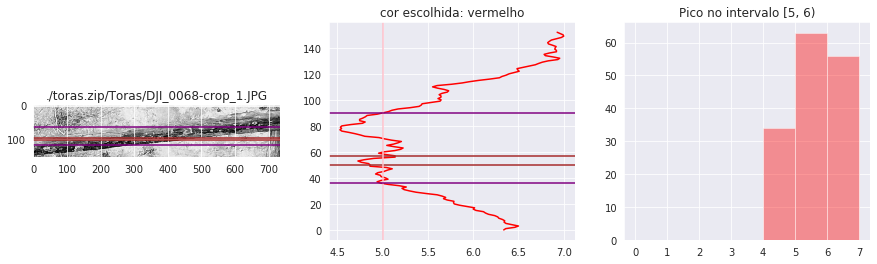

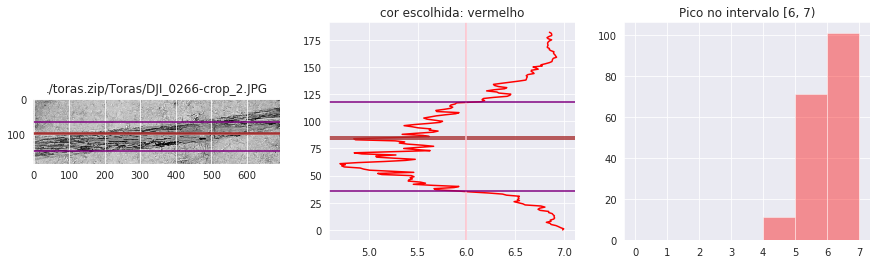

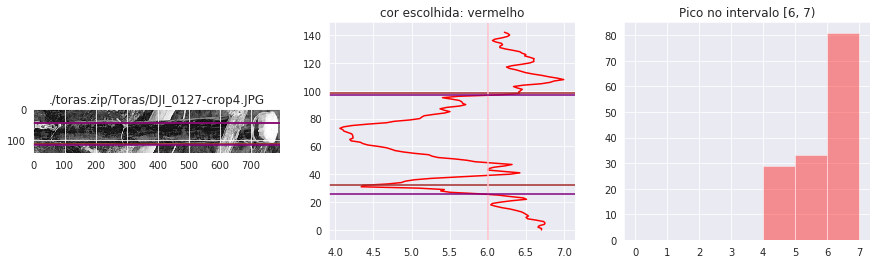

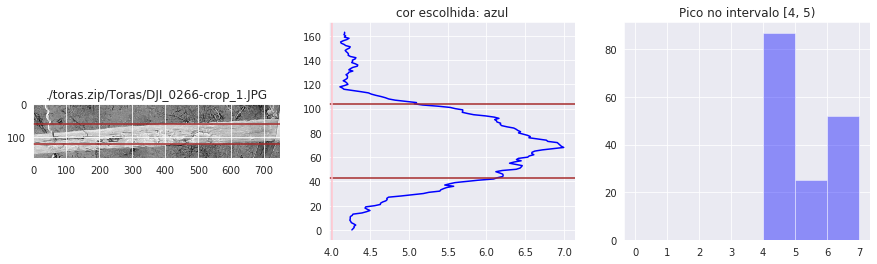

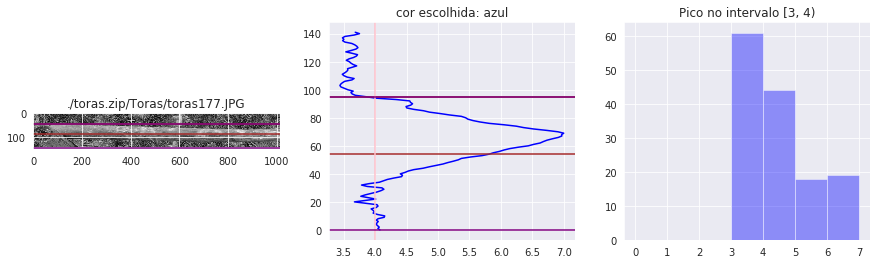

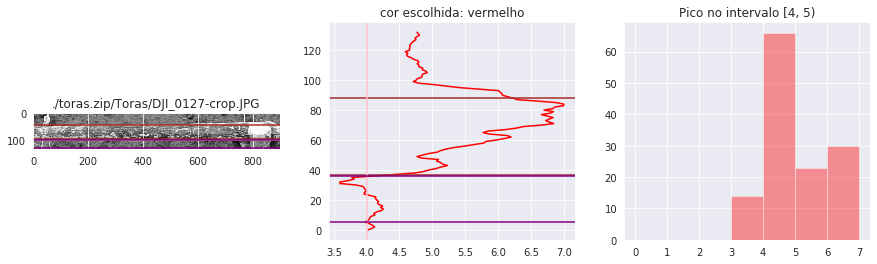

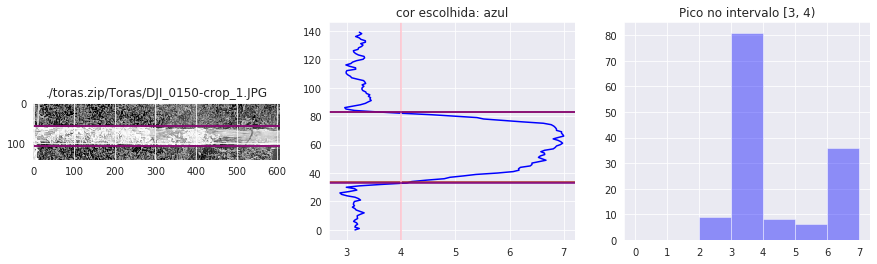

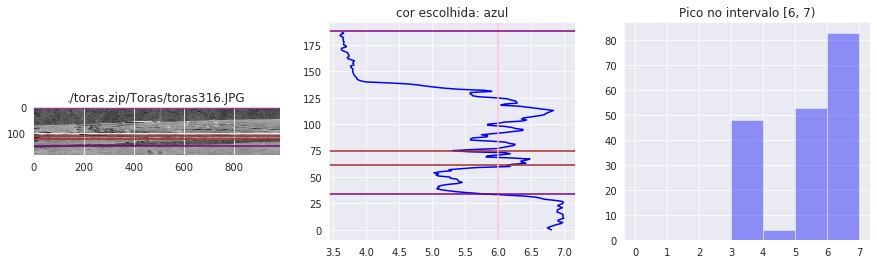

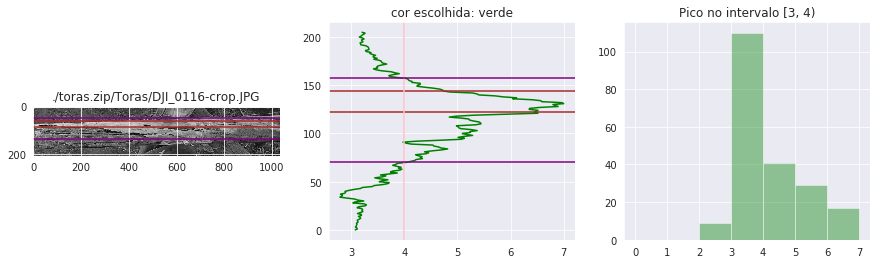

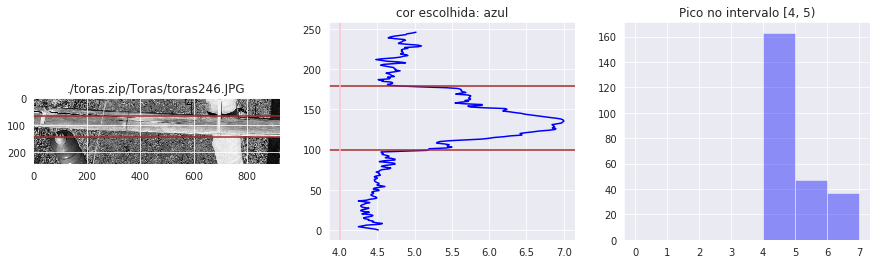

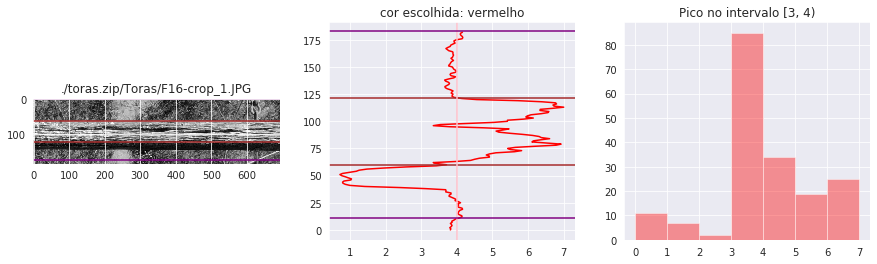

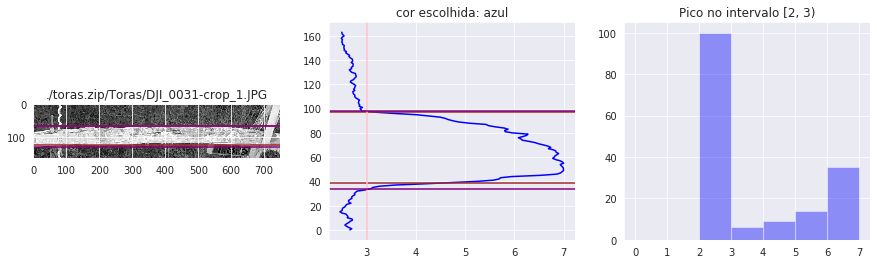

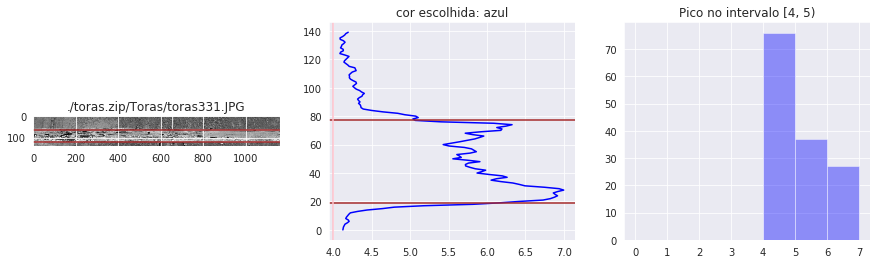

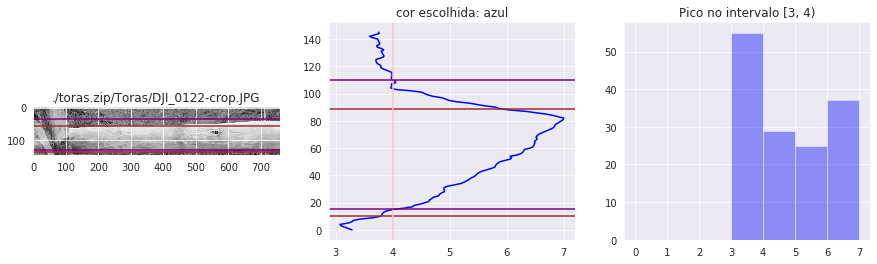

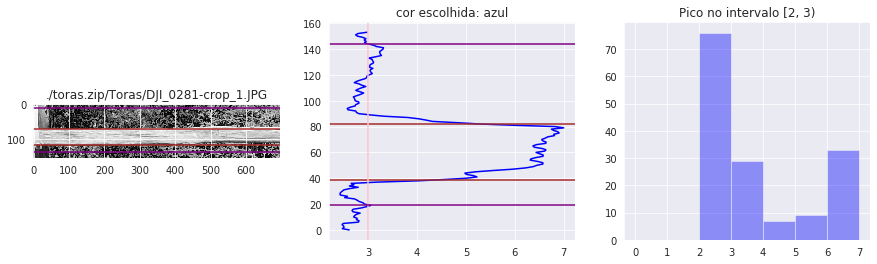

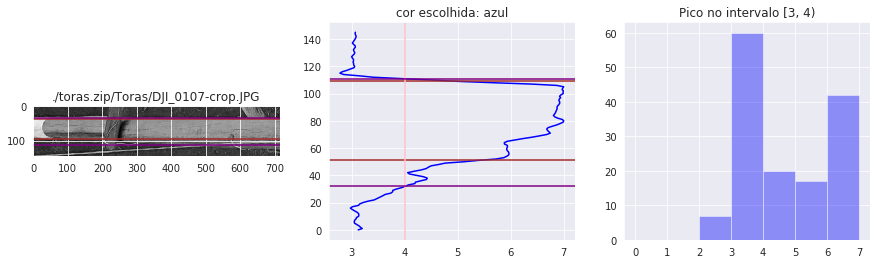

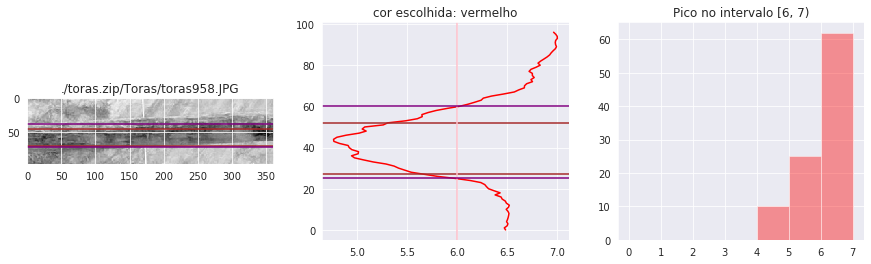

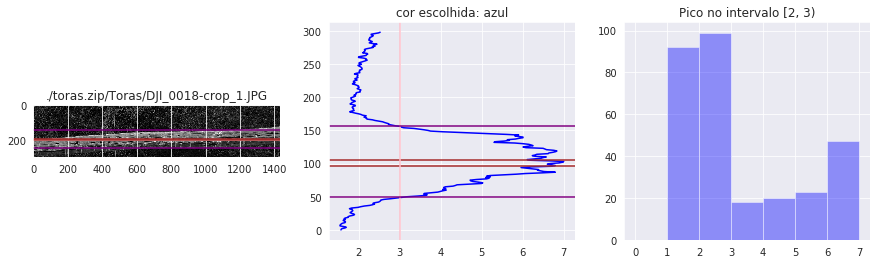

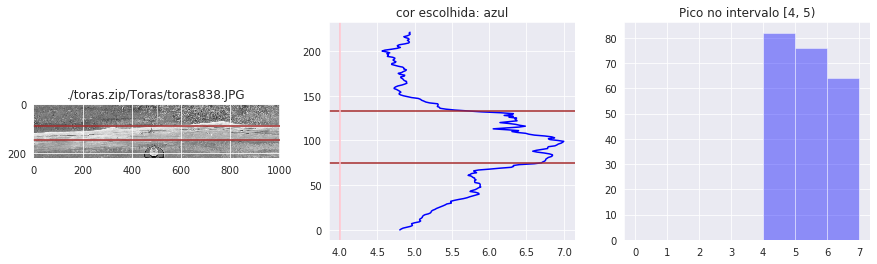

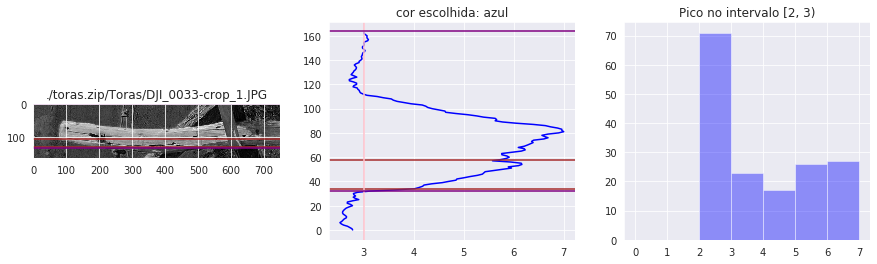

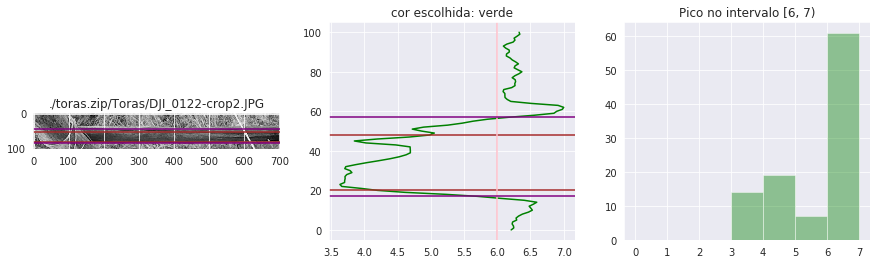

In [3]:
for path in path_list:
  # lendo imagem RGB
  img = imread(path)

  # Escolhendo qual cor apresenta maior variação
  cor_v, cor_h = best_rgb(img)

  # Plotando imagens
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

  # somas verticais e horizontais
  new_img = rgb_to_color(img, cor_h)
  h, w = new_img.shape

  soma_horizontal = new_img.sum(axis=1)
  soma_normalizada = soma_horizontal * (LIMITE_DE_NORMALIZACAO - 1)/soma_horizontal.max()
  
  # Exibindo imagem da cor selecionada
  ax[0].title.set_text(path)
  ax[0].imshow(new_img)
  
  # Plotando soma horizontal
  ax[1].title.set_text(f'cor escolhida: {COLOR_NAMES[cor_h]}')
  ax[1].plot(soma_normalizada,
             range(h-1, -1, -1),
             COLOR_CODES[cor_h])

  # Desenhando linhas sobre borda da tora (Método antigo por 1° derivada)
  diff_h:np.ndarray = np.diff(soma_horizontal)
  maximo = diff_h.argmax()
  minimo = diff_h.argmin()
  for j in [maximo, minimo]:
    ax[0].axhline(j, color='brown')
    ax[1].axhline(h - j, color='brown')

  # Desenhando linhas sobre borda da tora
  hist, bins = np.histogram(soma_normalizada, range(LIMITE_DE_NORMALIZACAO))

  n = len(hist)
  pos = hist.argmax()
  limiar = bins[pos + int(pos < n/2)]
  ax[1].axvline(limiar, color='pink')
  # cond = '>' if pos < n/2 else '<'
  # print(f'para quando v {cond} {limiar}')  

  stop_cond = (lambda y: y > limiar) if pos < n/2 else (lambda y: y < limiar)
  # de cima para baixo
  for i, v in enumerate(soma_normalizada):
    if stop_cond(v):
      ax[0].axhline(i, color='purple')
      ax[1].axhline(h - i, color='purple')
      break
  # de baixo para cima
  for i, v in enumerate(soma_normalizada[::-1]):
    if stop_cond(v):
      ax[0].axhline(h - i, color='purple')
      ax[1].axhline(i, color='purple')
      break

  # Plotando histograma
  ax[2].title.set_text(f'Pico no intervalo [{bins[pos]}, {bins[pos] + 1})')
  sns.distplot(
    a=soma_normalizada,
    bins=range(LIMITE_DE_NORMALIZACAO),
    kde=False,
    ax=ax[2],
    color=COLOR_CODES[cor_h][0])

  plt.show()
